In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine


In [3]:
from _element import feature_control as ft_c
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

In [4]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj.xlsx'
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)
df_temp= ft_c.xlsx_opener(path_name+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [5]:
y_col= df_raw['raw'].columns.values.tolist()
try:
    y_col.remove('ds')
except ValueError:
    pass
y_col_reduced= ['ds', 1041]
df_raw['raw']= df_raw['raw'][y_col_reduced]
y_col_reduced.remove('ds')

In [6]:
x_col= df_temp['raw'].columns.values.tolist()
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [7]:
df_raw['raw']['ds']= pd.to_datetime(df_raw['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_temp['raw']['ds']= pd.to_datetime(df_temp['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_raw['raw']= pd.merge(df_raw['raw'], df_temp['raw'], how='inner', on='ds')

In [8]:
ft_c.add_division(df_raw, 'raw', 365)
ft_c.add_division(df_raw, 'raw', 7, start_num= 3)

In [9]:
condition_mask= ((df_raw['raw']['seasonality_365,0']>=15)&(df_raw['raw']['seasonality_365,0']<165))

df_raw['raw']['seasonality_365,0'].where(condition_mask, 0, inplace= True)
df_raw['raw']['seasonality_365,0'].mask(condition_mask, 1, inplace= True)

df_raw['raw']['seasonality_7,3']= df_raw['raw']['seasonality_7,3'].replace(to_replace= [0,1,2,3,4,5,6], value= ['mon','tue','wed','thu','fri','sat','sun'])

In [11]:
ft_c.divide_by(df_raw, 'raw', 'seasonality_365,0')

In [14]:
ft_c.divide_by(df_raw, (0,), 'seasonality_7,3', div_set= {('mon','tue','wed','thu','fri', 'sat',), ('sun',)})
ft_c.divide_by(df_raw, (1,), 'seasonality_7,3', div_set= {('mon','tue','wed','thu','fri', 'sat',), ('sun',)})

In [12]:
for i in [('mon','tue','wed','thu','fri', 'sat', ),('sun', )]:
    ft_c.divide_multiple_y(df_raw, i, y_col_reduced, x_col, checkpoint= i)

In [15]:
df_raw

{('mon',
  'tue',
  'wed',
  'thu',
  'fri',
  'sat'):              ds  1041   temp_max   temp_min  rain_amount  seasonality_365,0  \
 15   2010-07-16  4041  27.100000  21.700001         52.0                  1   
 16   2010-07-17  4452  24.299999  22.299999         89.0                  1   
 18   2010-07-19  4382  29.299999  24.200001          0.0                  1   
 19   2010-07-20  6859  32.000000  26.700001          0.0                  1   
 20   2010-07-21  6589  29.500000  26.000000          0.0                  1   
 21   2010-07-22  6062  29.299999  24.500000          5.0                  1   
 22   2010-07-23  9022  25.000000  23.200001          2.0                  1   
 23   2010-07-24  3494  29.200001  23.600000          1.0                  1   
 25   2010-07-26  4642  27.600000  23.400000          6.0                  1   
 26   2010-07-27  4483  30.100000  19.400000          0.0                  1   
 27   2010-07-28  7094  30.600000  24.700001          1.0         

In [14]:
r= Result()

In [15]:
cv= Cross_Validation(df_raw)

In [16]:
cv.slice('y', x_col, forecastday= varr.FORECASTDAY)

In [17]:
cv._data

{"0_1041_('mon', 'tue', 'wed', 'thu', 'fri')": {'test':              ds  temp_max  temp_min  rain_amount     y
  2703 2017-11-24       2.9      -2.5          0.1  8733
  2706 2017-11-27       8.1       1.8          0.0  4866
  2707 2017-11-28       9.8       4.2          1.2  5723
  2708 2017-11-29       5.7      -3.2          0.0  6732
  2709 2017-11-30       1.8      -7.1          0.0  6909,
  'testX':              ds  temp_max  temp_min  rain_amount
  2703 2017-11-24       2.9      -2.5          0.1
  2706 2017-11-27       8.1       1.8          0.0
  2707 2017-11-28       9.8       4.2          1.2
  2708 2017-11-29       5.7      -3.2          0.0
  2709 2017-11-30       1.8      -7.1          0.0,
  'testY': 2703    8733
  2706    4866
  2707    5723
  2708    6732
  2709    6909
  Name: y, dtype: int64,
  'train':              ds   temp_max   temp_min  rain_amount     y
  0    2010-07-01  30.500000  24.900000          0.0  5698
  1    2010-07-02  25.799999  22.700001         70.

In [18]:
prpt_withobj= Prophet_timeseries(cv= True)

In [19]:
prpt_withobj.add_model('obj', 'day', regressor= False)

In [20]:
prpt_withobj.fit('obj', txs_traintest= cv._data)

In [21]:
prpt_withobj.forecast('obj', forecast_dict= r.forecast_dict)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_alg\prophet.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result_forecast['ds'], box=True, format= '%Y/%m/%d', exact=True


In [22]:
r.forecast_dict

OrderedDict([("obj_0_1041_('mon', 'tue', 'wed', 'thu', 'fri')",
              {'forecast':           ds  temp_max  temp_min  rain_amount     y         yhat
               0 2017-11-24       2.9      -2.5          0.1  8733  6821.667066
               1 2017-11-27       8.1       1.8          0.0  4866  5025.131871
               2 2017-11-28       9.8       4.2          1.2  5723  5490.106140
               3 2017-11-29       5.7      -3.2          0.0  6732  5772.872735
               4 2017-11-30       1.8      -7.1          0.0  6909  5632.555469}),
             ("obj_1_1041_('mon', 'tue', 'wed', 'thu', 'fri')",
              {'forecast':           ds   temp_max   temp_min  rain_amount     y         yhat
               0 2017-09-15  27.299999  17.200001          0.0  6768  7051.557387
               1 2017-09-18  27.100000  19.200001          0.0  9038  5136.636233
               2 2017-09-19  25.900000  14.900000          5.8  5969  5428.391479
               3 2017-09-20  23.50000

In [23]:
forecast_case= []
for i in range(5):
    for feature in y_col_reduced:
        forecast_case.append('{}_{}'.format(str(i), str(feature)))
print(forecast_case)
r.merge_result(forecast_case)

['0_1041', '0_1692', '1_1041', '1_1692', '2_1041', '2_1692', '3_1041', '3_1692', '4_1041', '4_1692']


In [24]:
r.err_rate()

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
r.avg_result(list(map(str, y_col_reduced)))

In [26]:
r.print_err_rate()

RMSE with segment 1041_result: 1544.6874
MAPE with segment 1041_result: nan
MAPE_with_std with segment 1041_result: 34.3905
MAPE_div_std with segment 1041_result: 110.1777
sMAPE with segment 1041_result: 21.8632


RMSE with segment 1692_result: 1411.6352
MAPE with segment 1692_result: nan
MAPE_with_std with segment 1692_result: 22.1598
MAPE_div_std with segment 1692_result: 81.6626
sMAPE with segment 1692_result: 7.9386




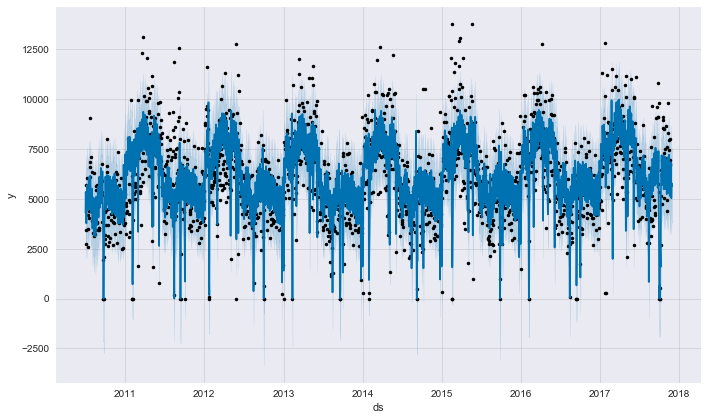

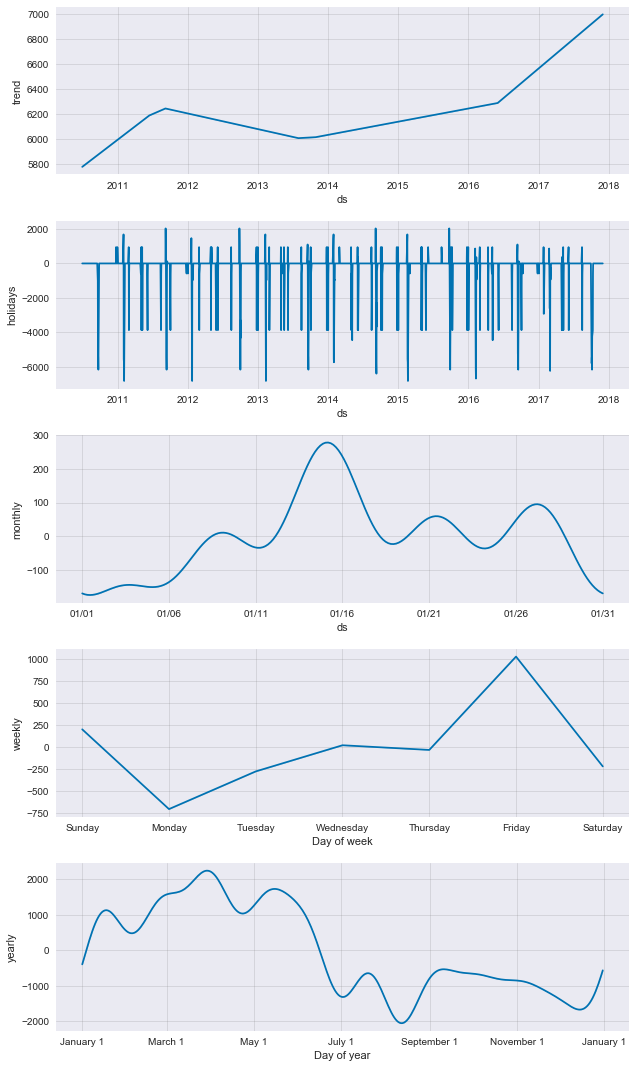

In [106]:
prpt_withobj.plot("obj_0_1041_('mon', 'tue', 'wed', 'thu', 'fri')")

In [73]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj.xlsx'
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)
df= df_raw['raw']

In [74]:
df.head()

,ds,1025,1041,1057,1091,1111,1117,1119,1127,1163,...,1754,1797,1800,1815,1817,1852,1853,1878,1891,y_sum
0,2010-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,2652,0,0,0,0,0,2662
1,2010-01-02,192,6260,0,0,0,0,0,0,0,...,337,0,0,26443,0,0,459,626,0,39352
2,2010-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,404,0,0,0,0,0,404
3,2010-01-04,0,5141,0,320,0,0,0,0,0,...,154,576,0,22924,0,0,3445,3305,0,44906
4,2010-01-05,130,5494,0,1186,0,0,0,0,0,...,367,294,0,39081,320,0,3861,4362,238,69481


In [75]:
ft_c.add_division(df_raw, 'raw', 7, start_num= 4)

In [77]:
ft_c.divide_by(df_raw, 'raw', 'seasonality_7,4', div_set= {(0,1,2,3,4), (5,), (6,)})

In [78]:
series_1041= df_raw[(0,1,2,3,4)][1041]
df_1041= df_raw[(0,1,2,3,4)][['ds', 1041]].reset_index(drop= True)

In [79]:
series_1692= df_raw[(0,1,2,3,4)][1692]

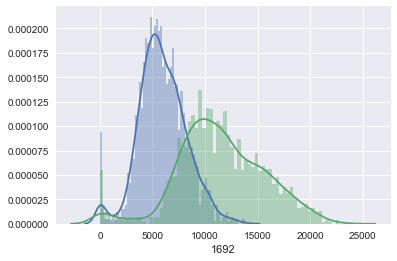

In [80]:
sns.set()
sns.distplot(series_1041, bins= 70)
sns.distplot(series_1692, bins= 70)
plt.show()

In [81]:
gm= GaussianMixture(n_components= 2)
gm.fit(np.array(series_1041).reshape(-1, 1))
print('case {}: {}'.format(i, gm.aic(np.array(series_1041).reshape(-1, 1))))
print(gm.means_)

case 8: 37726.82317915671
[[ 7487.40512456]
 [ 5045.70449672]]


In [82]:
prob_1041= pd.DataFrame(gm.predict_proba(np.array(series_1041).reshape(-1, 1)))

In [83]:
pd.concat([df_1041, prob_1041], axis= 1)

,ds,1041,0,1
0,2010-01-01,0,0.027967,0.972033
1,2010-01-04,5141,0.214251,0.785749
2,2010-01-05,5494,0.252471,0.747529
3,2010-01-06,10300,0.930228,0.069772
4,2010-01-07,11193,0.968616,0.031384
5,2010-01-08,12480,0.991212,0.008788
6,2010-01-11,6268,0.356769,0.643231
7,2010-01-12,4820,0.184304,0.815696
8,2010-01-13,6615,0.412154,0.587846
9,2010-01-14,6677,0.422524,0.577476


In [105]:
df_raw[(0,1,2,3,4)].loc[
    df_raw[(0,1,2,3,4)]['ds']>= pd.Timestamp('2017-01-01 00:00:00'), :
    ].loc[
    df_raw[(0,1,2,3,4)].loc[:, 1041]>= 7500
    ].loc[
    :, ['ds', 1041]
    ].iloc[
    :30, :
    ]

,ds,1041
2569,2017-01-13,11304
2574,2017-01-18,7900
2575,2017-01-19,8324
2576,2017-01-20,9046
2579,2017-01-23,8310
2580,2017-01-24,8008
2581,2017-01-25,12784
2582,2017-01-26,10165
2589,2017-02-02,8264
2590,2017-02-03,11170


In [88]:
df_raw[(0,1,2,3,4)].loc[300, 'ds']

Timestamp('2010-10-28 00:00:00')

In [107]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj.xlsx'
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)
df= df_raw['raw']

In [108]:
df.head()

,ds,1025,1041,1057,1091,1111,1117,1119,1127,1163,...,1754,1797,1800,1815,1817,1852,1853,1878,1891,y_sum
0,2010-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,2652,0,0,0,0,0,2662
1,2010-01-02,192,6260,0,0,0,0,0,0,0,...,337,0,0,26443,0,0,459,626,0,39352
2,2010-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,404,0,0,0,0,0,404
3,2010-01-04,0,5141,0,320,0,0,0,0,0,...,154,576,0,22924,0,0,3445,3305,0,44906
4,2010-01-05,130,5494,0,1186,0,0,0,0,0,...,367,294,0,39081,320,0,3861,4362,238,69481


In [109]:
ft_c.add_division(df_raw, 'raw', 365)

In [125]:
df_raw['raw'].head()

,ds,1025,1041,1057,1091,1111,1117,1119,1127,1163,...,1797,1800,1815,1817,1852,1853,1878,1891,y_sum,"seasonality_365,0"
0,2010-01-01,0,0,0,0,0,0,0,0,0,...,0,0,2652,0,0,0,0,0,2662,0
1,2010-01-02,192,6260,0,0,0,0,0,0,0,...,0,0,26443,0,0,459,626,0,39352,0
2,2010-01-03,0,0,0,0,0,0,0,0,0,...,0,0,404,0,0,0,0,0,404,0
3,2010-01-04,0,5141,0,320,0,0,0,0,0,...,576,0,22924,0,0,3445,3305,0,44906,0
4,2010-01-05,130,5494,0,1186,0,0,0,0,0,...,294,0,39081,320,0,3861,4362,238,69481,0


In [127]:
df_raw['raw'][(df_raw['raw']['seasonality_365,0']==1)]

,ds,1025,1041,1057,1091,1111,1117,1119,1127,1163,...,1797,1800,1815,1817,1852,1853,1878,1891,y_sum,"seasonality_365,0"
15,2010-01-16,0,4514,0,50,0,0,0,0,0,...,2322,0,29985,0,0,5260,1770,0,54602,1
16,2010-01-17,0,0,0,0,0,0,0,0,0,...,0,0,568,0,0,0,0,0,568,1
17,2010-01-18,40,3975,0,320,0,0,0,0,0,...,778,0,44099,0,0,4825,4119,464,75083,1
18,2010-01-19,51,6918,0,388,0,0,0,0,0,...,0,0,42713,320,0,4698,5569,320,76767,1
19,2010-01-20,245,3567,0,224,0,0,0,0,0,...,161,0,40365,0,0,5217,3824,144,71655,1
20,2010-01-21,252,4758,0,32,0,0,0,100,0,...,1379,0,34943,0,0,4728,5163,0,69342,1
21,2010-01-22,360,3970,0,414,0,0,0,0,0,...,720,30,37524,0,0,4636,6225,144,71053,1
22,2010-01-23,0,4852,0,128,0,0,0,0,0,...,538,0,29112,0,0,3410,1806,758,48681,1
23,2010-01-24,0,100,0,0,0,0,0,0,0,...,0,0,1500,0,0,400,192,0,2192,1
24,2010-01-25,144,6644,0,488,0,0,0,137,0,...,632,0,38761,0,0,4404,3256,0,68989,1


In [121]:
condition_mask= ((df_raw['raw']['seasonality_365,0']>=15)&(df_raw['raw']['seasonality_365,0']<165))

df_raw['raw']['seasonality_365,0'].where(condition_mask, 0, inplace= True)
df_raw['raw']['seasonality_365,0'].mask(condition_mask, 1, inplace= True)